In [1]:
#import torch
import matplotlib.pyplot as plt
import numpy as np
#import torch
#import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
#import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
#from torchvision import transforms, datasets
import cv2
#from torchvision import transforms, datasets
import pandas as pd
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt


#if torch.cuda.is_available():
#    DEVICE = torch.device('cuda')
#else:
#    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
#print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
# 하이퍼 파라미터 서치 내용. 08. 05
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [4]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.
import librosa, librosa.display


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


In [14]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

In [15]:
phrase_dict

{'1040-phrase.wav': array([ 0.00019198,  0.00072988,  0.00077416, ...,  0.00010608,
        -0.00024016,  0.        ], dtype=float32),
 '1045-phrase.wav': array([-0.00301087, -0.00471198, -0.00369397, ...,  0.00877707,
         0.00960897,  0.        ], dtype=float32),
 '1046-phrase.wav': array([0.00087176, 0.00210954, 0.0017544 , ..., 0.02247776, 0.02591118,
        0.        ], dtype=float32),
 '1047-phrase.wav': array([-0.00218182, -0.0038823 , -0.00290296, ..., -0.00242876,
        -0.00317664,  0.        ], dtype=float32),
 '1048-phrase.wav': array([ 0.0023579 ,  0.00356342,  0.00313498, ..., -0.00019799,
        -0.0001939 ,  0.        ], dtype=float32),
 '1049-phrase.wav': array([ 0.00102539,  0.00163141,  0.00010494, ..., -0.01097467,
        -0.01524004,  0.        ], dtype=float32),
 '105-phrase.wav': array([0.00335465, 0.0054294 , 0.00509842, ..., 0.00176289, 0.00259548,
        0.        ], dtype=float32),
 '1052-phrase.wav': array([ 0.00707356,  0.01187314,  0.00938601, ..

In [17]:

spectros=[]

mels=[]

sr=16000

for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=sr*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    sig_torch = torch.tensor(sig,dtype=torch.float32)


    #MFCCs = MFCC(sig_torch)

    stft = librosa.stft(sig, win_length=spectro_run_config['win_length'],
                        n_fft=spectro_run_config['n_fft'],
                        hop_length=spectro_run_config['hop_length'])
    
    mel_feature = librosa.feature.melspectrogram(y=sig,
                                                 sr=sr,
                                                 win_length=mel_run_config['win_length'],
                                                 hop_length=mel_run_config['hop_length'],
                                                 n_fft=mel_run_config['n_fft'],
                                                 fmax=mel_run_config['f_max'])
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    #print(value[0])
    spectros.append(log_spectrogram) # spectrogram
    #print(value[0])
    mels.append(mel_feature) # spectrogram


(array([5.15551872e-02, 1.50369296e-02, 1.51283395e-02, 1.74166342e-02,
        2.08871636e-02, 2.32546802e-02, 2.27336437e-02, 1.96409419e-02,
        1.73282713e-02, 1.43970603e-02, 1.11337266e-02, 8.15376365e-03,
        5.55467531e-03, 3.53146938e-03, 2.18774376e-03, 9.68945008e-04,
        5.33224454e-04, 3.38216654e-04, 1.55396841e-04, 6.39869345e-05]),
 array([-80., -76., -72., -68., -64., -60., -56., -52., -48., -44., -40.,
        -36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,   0.],
       dtype=float32),
 <BarContainer object of 20 artists>)

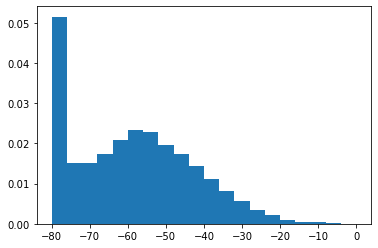

In [68]:
implt.hist(np.round(mels[11]).reshape(-1),density=True,histtype='bar',bins=20)

In [144]:
#import time
#for i in range(600):
    #plt.hist(np.round(spectros[i]).reshape(-1),density=True,histtype='bar',bins=20)
    #plt.show()
    #time.sleep(1)

In [139]:
#import time
#for i in range(600):
    plt.hist(np.round(mels[i]).reshape(-1),density=True,histtype='bar',bins=20)
    #plt.show()
    #time.sleep(1)

IndentationError: unexpected indent (Temp/ipykernel_15108/3236788332.py, line 3)

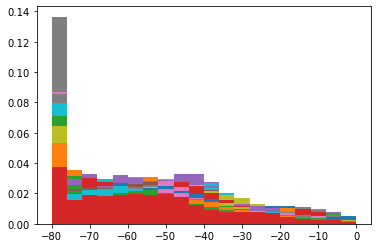

In [81]:
spectro_bins=[]
mel_bins=[]

for mel in mels:
    mel_plot=plt.hist(np.round( mel ).reshape(-1),density=True,histtype='bar',bins=20)
    mel_bins.append( mel_plot[0] )
    


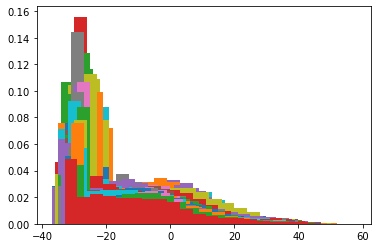

In [82]:
for spectro in spectros:
    spectro_plot=plt.hist(np.round( spectro ).reshape(-1),density=True,histtype='bar',bins=20)
    spectro_bins.append( spectro_plot[0] )

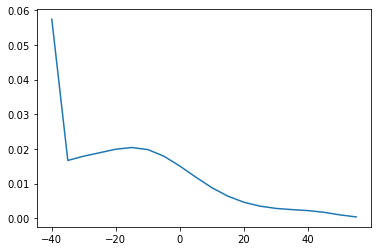

In [103]:
plt.plot(np.arange(-40,60,5),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

(array([0.01016173, 0.01129522, 0.01820581, 0.02454965, 0.02966251,
        0.03162173, 0.02945227, 0.02656981, 0.02051848, 0.01315389,
        0.00771195, 0.00467409, 0.00334256, 0.00310184, 0.00306528,
        0.00272706, 0.00312927, 0.00266917, 0.00337912, 0.00100856]),
 array([-36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,   0.,   4.,
          8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.],
       dtype=float32),
 <BarContainer object of 20 artists>)

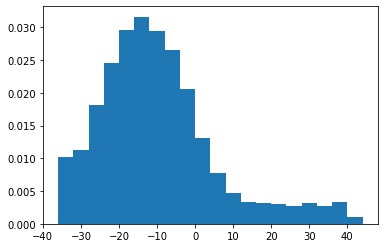

In [106]:
plt.hist(np.round(spectros[8]).reshape(-1),density=True,histtype='bar',bins=20)

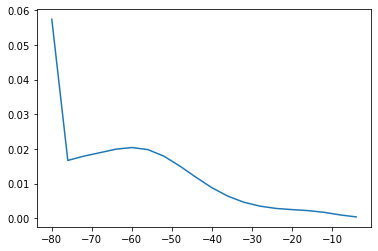

In [108]:

plt.plot(np.arange(-80, 0,4),np.array(spectro_bins).mean(axis=0))
#plt.yticks()

In [19]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T


# mfcc 20 (2~27) norm 값 찾기.
# 0627 추가
# 0726 lift norm 후에 활용.

#sr=16000
#win_length =  np.int64(sr/40) # 
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4



# 하이퍼 파라미터 서치 내용. 08. 05
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mfcc_mean=[]
mfcc_std=[]

cep_lifter=35


for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=mfcc_run_config['sr']*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
    
    sig = pad1d(sig,length)
    sig = (sig-sig.mean())/sig.std()
    
    sig_torch=torch.tensor(sig, dtype=torch.float32)


    MFCC = T.MFCC(
                    sample_rate = mfcc_run_config["sr"],
                    n_mfcc = mfcc_run_config["n_mfcc"],
                    melkwargs={
                        'n_fft': mfcc_run_config["n_fft"],
                        'n_mels': mfcc_run_config["n_mels"],
                        'hop_length': mfcc_run_config["hop_length"],
                        'mel_scale': mfcc_run_config["mel_scale"],
                        'win_length' : mfcc_run_config["win_length"],
                        'f_max': mfcc_run_config["f_max"]
                    }
                )

    MFCCs=MFCC(sig_torch)
    MFCCs = MFCCs[1:,]
    (nframes, ncoeff) = MFCCs.shape
    cep_lifter = mfcc_run_config["lifter"]

    #log_spectrogram = phrase_scaler[0].transform(log_spectrogram.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)
    #mel_feature=phrase_scaler[1].transform(mel_feature.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)            

    if cep_lifter > 0:
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        MFCCs *= lift


    #print(value[0])
    mfcc_mean.append(MFCCs.mean(axis=1).mean()) # spectrogram
    mfcc_std.append(MFCCs.mean(axis=1).std())
    #mfcc_std.append(MFCCs.std()) # spectrogram    
    
    

print('mfcc 27 mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

mfcc 27 mean, std :  53.558239820255636 217.42984465872607


In [5]:

sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4

spectro_mean=[]
spectro_std=[]

mel_mean=[]
mel_std=[]

mfcc_mean=[]
mfcc_std=[]


for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=29990 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    
    sig = librosa.effects.preemphasis(sig)    
    
    sig = (sig-sig.mean())/sig.std()
    


    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    #print(value[0])
    spectro_mean.append(log_spectrogram.mean()) # spectrogram
    spectro_std.append(log_spectrogram.std()) # spectrogram
    
    #print(value[0])
    mel_mean.append(mel_feature.mean()) # spectrogram
    mel_std.append(mel_feature.std()) # spectrogram
    
    #print(value[0])
    mfcc_mean.append(MFCCs.mean()) # spectrogram
    mfcc_std.append(MFCCs.std()) # spectrogram    
    
    
    
    

print('spectro mean, std : ',np.mean(spectro_mean),np.mean(spectro_std))
print('mel mean, std : ',np.mean(mel_mean),np.mean(mel_std))
print('mfcc mean, std : ',np.mean(mfcc_mean),np.mean(mfcc_std))

spectro mean, std :  0.18445877507786745 15.70498345259471
mel mean, std :  -48.57786740353503 15.841430412008151
mfcc mean, std :  -1.6147918875282348 21.550443776314548


In [6]:
# min-max normalizer
from sklearn.preprocessing import MinMaxScaler
import pickle


sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4

spectro=[]

mel=[]

mfcc=[]


for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=29990 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)
    sig = librosa.effects.preemphasis(sig)    
    sig = (sig-sig.mean())/sig.std()
    


    MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)

    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    
    mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm


    #padding
    #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    #log_spectrogram = pad2d(log_spectrogram, length)
    #mel_feature = pad2d(mel_feature, length)

    #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    
    
    #print(value[0])
    spectro.append(log_spectrogram.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mel.append(mel_feature.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mfcc.append(MFCCs.reshape(-1,1)) # spectrogram

scaler_spectro = MinMaxScaler()
scaler_mel = MinMaxScaler()
scaler_mfcc = MinMaxScaler()

scaler_spectro.fit(np.array(spectro).squeeze(2))
scaler_mel.fit(np.array(mel).squeeze(2))
scaler_mfcc.fit(np.array(mfcc).squeeze(2))


MinMaxScaler()

In [102]:
# min max sclaer
#train set에서만 min max scaler를 fit 시킨다.
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt


# 하이퍼 파라미터 서치 내용. 08. 05
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)



mel_list = []
spectro_list = []
mfcc_list = []


for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=16000*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)  
    sig = (sig-sig.mean())/sig.std()

    stft = librosa.stft(sig, win_length=spectro_run_config["win_length"],
                            n_fft=spectro_run_config["n_fft"],
                            hop_length=spectro_run_config["hop_length"]
                               )

    mel_feature = librosa.feature.melspectrogram(y=sig,
                                             sr=mel_run_config["sr"],
                                             # hyp param
                                             n_mels = mel_run_config["n_mels"],
                                             n_fft = mel_run_config["n_fft"],
                                             win_length = mel_run_config["win_length"],
                                             hop_length = mel_run_config["hop_length"],
                                             fmax = mel_run_config["f_max"]
                                            )
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    
    ### mfcc ###
    sig_torch=torch.tensor(sig, dtype=torch.float32)


    MFCC = T.MFCC(
                    sample_rate = mfcc_run_config["sr"],
                    n_mfcc = mfcc_run_config["n_mfcc"],
                    melkwargs={
                        'n_fft': mfcc_run_config["n_fft"],
                        'n_mels': mfcc_run_config["n_mels"],
                        'hop_length': mfcc_run_config["hop_length"],
                        'mel_scale': mfcc_run_config["mel_scale"],
                        'win_length' : mfcc_run_config["win_length"],
                        'f_max': mfcc_run_config["f_max"]
                    }
                )

    MFCCs=MFCC(sig_torch)
    MFCCs = MFCCs[1:,]
    (nframes, ncoeff) = MFCCs.shape
    cep_lifter = mfcc_run_config["lifter"]

    #log_spectrogram = phrase_scaler[0].transform(log_spectrogram.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)
    #mel_feature=phrase_scaler[1].transform(mel_feature.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)            

    if cep_lifter > 0:
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        MFCCs *= lift
    
    #print(value[0])
    spectro_list.append(log_spectrogram.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mel_list.append(mel_feature.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mfcc_list.append(MFCCs.reshape(-1,1).numpy()) # spectrogram

scaler_spectro = MinMaxScaler()
scaler_mel = MinMaxScaler()
scaler_mfcc = MinMaxScaler()

scaler_spectro.fit(np.array(spectro_list).squeeze(2))
scaler_mel.fit(np.array(mel_list).squeeze(2))
scaler_mfcc.fit(np.array(mfcc_list).squeeze(2))


MinMaxScaler()

In [ ]:


# STDnorm sclaer
#train set에서만 min max scaler를 fit 시킨다.
from sklearn.preprocessing import StandardScaler
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt


# 하이퍼 파라미터 서치 내용. 08. 05
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)



mel_list = []
spectro_list = []
mfcc_list = []


for key in X:
    #print(key)
    sig =  phrase_dict[key] # 16000hz 실시
    length=16000*2 #300 padding을 위한 파라미터
    pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
    sig = pad1d(sig,length)  
    sig = (sig-sig.mean())/sig.std()

    stft = librosa.stft(sig, win_length=spectro_run_config["win_length"],
                            n_fft=spectro_run_config["n_fft"],
                            hop_length=spectro_run_config["hop_length"]
                               )

    mel_feature = librosa.feature.melspectrogram(y=sig,
                                             sr=mel_run_config["sr"],
                                             # hyp param
                                             n_mels = mel_run_config["n_mels"],
                                             n_fft = mel_run_config["n_fft"],
                                             win_length = mel_run_config["win_length"],
                                             hop_length = mel_run_config["hop_length"],
                                             fmax = mel_run_config["f_max"]
                                            )
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm

    #stft 300 FRAME이 되도록 패딩.
    #length = 300

    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
    
    
    ### mfcc ###
    sig_torch=torch.tensor(sig, dtype=torch.float32)


    MFCC = T.MFCC(
                    sample_rate = mfcc_run_config["sr"],
                    n_mfcc = mfcc_run_config["n_mfcc"],
                    melkwargs={
                        'n_fft': mfcc_run_config["n_fft"],
                        'n_mels': mfcc_run_config["n_mels"],
                        'hop_length': mfcc_run_config["hop_length"],
                        'mel_scale': mfcc_run_config["mel_scale"],
                        'win_length' : mfcc_run_config["win_length"],
                        'f_max': mfcc_run_config["f_max"]
                    }
                )

    MFCCs=MFCC(sig_torch)
    MFCCs = MFCCs[1:,]
    (nframes, ncoeff) = MFCCs.shape
    cep_lifter = mfcc_run_config["lifter"]

    #log_spectrogram = phrase_scaler[0].transform(log_spectrogram.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)
    #mel_feature=phrase_scaler[1].transform(mel_feature.reshape(1,-1)).reshape(self.mel_params["n_mels"],time_len)            

    if cep_lifter > 0:
        n = np.arange(ncoeff)
        lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
        MFCCs *= lift
    
    #print(value[0])
    spectro_list.append(log_spectrogram.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mel_list.append(mel_feature.reshape(-1,1)) # spectrogram
    
    #print(value[0])
    mfcc_list.append(MFCCs.reshape(-1,1)) # spectrogram

scaler_spectro = StandardScaler()
scaler_mel = StandardScaler()
scaler_mfcc = StandardScaler()

scaler_spectro.fit(np.array(spectro_list).squeeze(2))
scaler_mel.fit(np.array(mel_list).squeeze(2))
scaler_mfcc.fit(np.array(mfcc_list).squeeze(2))


In [103]:
scaler_list = [scaler_spectro,scaler_mel,scaler_mfcc]

In [104]:
## Save pickle
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_minmax_scaler_hyper.pickle","wb") as fw:
    pickle.dump(scaler_list, fw)

In [ ]:
## Save pickle
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_stdnorm_scaler_hyper.pickle","wb") as fw:
    pickle.dump(scaler_list, fw)